In [2]:
import numpy as np
import scipy as sp
from scipy import special
#import decimal as dc
#dc.getcontext().prec = 50

import mpmath
mpmath.mp.dps = 50

############################################
import matplotlib.pyplot as plt            #
plt.rcParams['figure.figsize'] = (16, 9)   #
############################################

In [3]:
def is_even(x):
    return x % 2 == 0

In [4]:
def logbinomial(a, b):
    return mpmath.loggamma(a + 1) - mpmath.loggamma(b + 1) - mpmath.loggamma(a - b + 1)

In [8]:
a = 0.0
def pdf_beta(p, s, f):
    def calc(p, s, f):
        return mpmath.exp((s - 1 + a) * mpmath.log(p) + mpmath.mpf(f - 1 + a) * mpmath.log(1 - p) - mpmath.log(mpmath.beta(s + a, f + a)))
    if isinstance(p, int) or isinstance(p, float):
        result = calc(p, s, f)
    else:
        result = np.zeros(len(p))
        for i in range(len(p)):
            pi = p[i]
            result[i] = calc(pi, s, f)
    return result

In [9]:
def custom_logsumexp_mpmath(logs, signs):
    positive_mask=signs>0
    #print type(positive_mask)
    #print np.array(logs)
    positive_logs=np.array(logs)[positive_mask]
    negative_logs=np.array(logs)[positive_mask==False]

    res_pos=mpmath.mpf(0.0)
    res_neg=None

    if(len(positive_logs)>0):
        #print(type([mpmath.exp(i-max(positive_logs)) for i in positive_logs]))
        res_pos = max(positive_logs) + mpmath.log(sum([mpmath.exp(i-max(positive_logs)) for i in positive_logs]))
        
    if(len(negative_logs)>0):
        res_neg = max(negative_logs) + mpmath.log(sum([mpmath.exp(i-max(negative_logs)) for i in negative_logs]))
    
    #print "repos/resneg", res_pos, res_neg
    
    if(res_neg is None):
        
        return res_pos, 1.0
   
    if(res_pos==res_neg):
        print("not enough precision!!!...")
        exit(-1)
        return None, None
    elif(res_pos==res_neg and res_pos==0):
        print("0?!")
        print(logs)
        exit(-1)
    if(res_neg<res_pos):
        #print("neg < pos")
        ## easy case .. subtracted number is smaller 
        return res_neg + mpmath.log(mpmath.exp(res_pos-res_neg) - 1), 1.0
    else:
        ## A-B < 0 -> A-B = - (B-A) 
        return res_pos + mpmath.log(mpmath.exp(res_neg-res_pos) - 1), -1.0

In [10]:
def log_hyper_2F1_below_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b1)):
        log_resu = logbinomial(b1 - 1 +a, n) + mpmath.loggamma(a1 + a2 + n +2*a) + mpmath.loggamma(a1 + a2 + b2 + 3*a) - mpmath.loggamma(a1 + a2 + b2 + n + 3*a) - mpmath.loggamma(a1 + a2 + 2*a) + n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum[0]
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1,-1]))
            return log_result[0]

def log_hyper_2F1_above_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b2)):
        log_resu = logbinomial(b2 - 1 +a, n) + mpmath.loggamma(a1 + a2 + n + 2*a) + mpmath.loggamma(a1 + a2 + b1 + 3*a) - mpmath.loggamma(a1 + a2 + b1 + n + 3*a) - mpmath.loggamma(a1 + a2 + 2*a) - n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    #print(log_results_even)
    #print(log_results_odd)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum[0]
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1,-1]))
            return log_result[0]

In [11]:
def pdf_bb_ratio(a1, a2, b1, b2, w):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + (a1 - 1.0) * mpmath.log(wi) + log_hyper_2F1_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - (1.0 + a2) * mpmath.log(wi) + log_hyper_2F1_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for i in range(len(w)):
            wi = w[i]
            result[i] = pdf_calc(wi)
    return result

In [12]:
def log_hyper_3F2_below_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b1)):
        log_resu = logbinomial(b1 - 1, n) + mpmath.loggamma(a1 + n) + mpmath.loggamma(a1 + a2 + n) + mpmath.loggamma(a1 + 1) + mpmath.loggamma(a1 + a2 + b2) - mpmath.loggamma(a1) - mpmath.loggamma(a1 + a2) - mpmath.loggamma(a1 + n + 1) - mpmath.loggamma(a1 + a2 + b2 + n) + n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum[0]
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1, -1]))
            return log_result[0]

def log_hyper_3F2_above_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b2)):
        log_resu = logbinomial(b2 - 1, n) + mpmath.loggamma(a2 + n) + mpmath.loggamma(a1 + a2 + n) + mpmath.loggamma(a2 + 1) + mpmath.loggamma(a1 + a2 + b1) - mpmath.loggamma(a2) - mpmath.loggamma(a1 + a2) - mpmath.loggamma(a2 + n + 1) - mpmath.loggamma(a1 + a2 + b1 + n) - n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum[0]
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1, -1]))
            return log_result[0]

In [13]:
def cdf_bb_ratio(a1, a2, b1, b2, w):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def cum_pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + a1 * mpmath.log(wi) - mpmath.log(a1) + log_hyper_3F2_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = 1 - mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - a2 * mpmath.log(wi) - mpmath.log(a2) + log_hyper_3F2_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = cum_pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for i in range(len(w)):
            wi = w[i]
            result[i] = cum_pdf_calc(wi)
    return result

In [14]:
error_size = 0.9
step_size = 0.0001 # for better precision 0.00001 or even smaller

def beta_error(x, a, b, errorsize = error_size, stepsize = step_size):
    if x < 0.5:
        low = 0.0
        top = 1.0 - stepsize
    elif x >= 0.5:
        low = 0.0 + stepsize
        top = 1.0

    interval = 1.0

    while interval >= errorsize:
        low_p = pdf_beta(low, a, b)
        top_p = pdf_beta(top, a, b)
        low_c = sp.special.betainc(a+1, b+1, low)
        top_c = sp.special.betainc(a+1, b+1, top)
        interval = top_c - low_c
        if low_p > top_p:
            top = top - stepsize
        else:
            low = low + stepsize
    return low, top

In [15]:
def ratio_error(x, a1, a2, b1, b2, errorsize = error_size, stepsize = step_size):
    if x < stepsize:
        low = 0
    else:
        low = x - stepsize
    top = x + stepsize
    
    interval = 0.0
    
    while interval < errorsize:
        low_p = pdf_bb_ratio(a1, a2, b1, b2, low)
        top_p = pdf_bb_ratio(a1, a2, b1, b2, top)
        low_c = cdf_bb_ratio(a1, a2, b1, b2, low)
        top_c = cdf_bb_ratio(a1, a2, b1, b2, top)
        interval = top_c - low_c
        if (low_p > top_p) and (low >= stepsize):
            low = low - stepsize
        else:
            top = top + stepsize
    return low, top

In [55]:
a1 = 2
b1 = 6
a2 = 8
b2 = 5

def dx(f, x):
    return abs(0-f(x))

def newton_method(f, df, x0, e):
    delta = dx(f, x0)
    while delta > e:
        x0 = x0 - f(x0)/df(x0)
        delta = dx(f, x0)
    #print('Root is: ', x0)
    return x0

def df(x):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + (a1 - 1.0) * mpmath.log(wi) + log_hyper_2F1_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - (1.0 + a2) * mpmath.log(wi) + log_hyper_2F1_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(x, int) or isinstance(x, float) or isinstance(x, mpmath.mpf):
        result = pdf_calc(x)
    else:
        result = np.zeros(len(x))
        for i in range(len(x)):
            wi = x[i]
            result[i] = pdf_calc(wi)
    return result

def f(x):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def cum_pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + a1 * mpmath.log(wi) - mpmath.log(a1) + log_hyper_3F2_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = 1 - mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - a2 * mpmath.log(wi) - mpmath.log(a2) + log_hyper_3F2_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(x, int) or isinstance(x, float) or isinstance(x, mpmath.mpf):
        result = cum_pdf_calc(x)
    else:
        result = np.zeros(len(x))
        for i in range(len(x)):
            wi = x[i]
            result[i] = cum_pdf_calc(wi)
    return result-k

k = 0.05
low_newt = newton_method(f, df, 0.3, 1e-10)
k = 0.95
top_newt = newton_method(f, df, 0.3, 1e-10)
print(f(top_newt) - f(low_newt))

0.8999999999248059042740569484664257869134475188678


Expectation value of fraction a/b: $E\left(\frac{a}{b}\right) = E(a)\cdot E(b^{-1})$

with $E(a) = \frac{a_1}{a_1+b_1}$

and $E(b^{-1}) = \int_{-\infty}^{\infty}\frac{b^{a_2-2} (1-b)^{b_2-1}}{B(a_2-1, b_2) \left(\frac{a_2-1}{a_2+b_2-1}\right)}\,\mathrm{d}b = \frac{a_2+b_2-1}{a_2-1}$

$\Rightarrow E(\frac{a}{b}) = \frac{a_1\cdot(a_2+b_2-1)}{(a_1+b_1)\cdot(a_2-1)}$

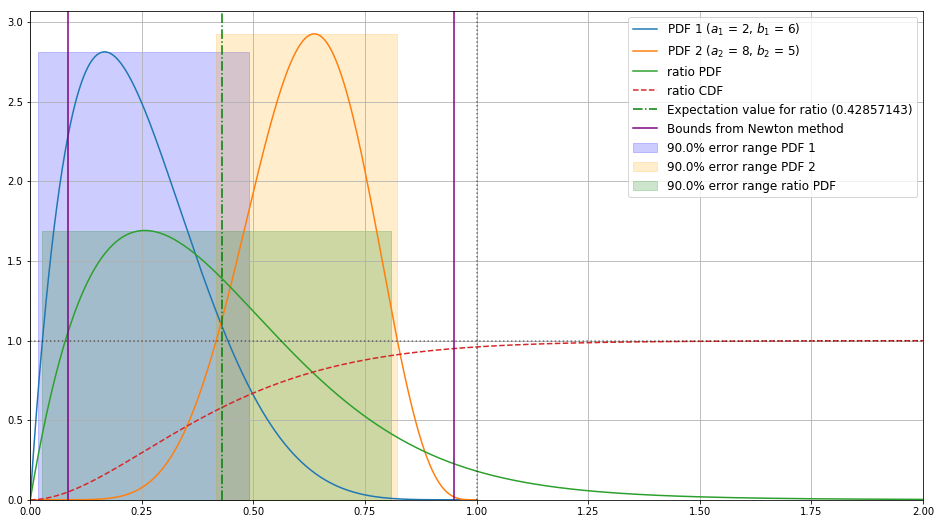

In [57]:
u = np.linspace(0, 1, 1001)
v = np.linspace(0,2.0,2001)

a1 = 2
b1 = 6
a2 = 8
b2 = 5

assert a2 != 1
assert a2 != 0
assert a1 != 0

pdf1 = pdf_beta(u, a1, b1)
pdf2 = pdf_beta(u, a2, b2)
ratio_pdf = pdf_bb_ratio(a1, a2, b1, b2, v)
ratio_cdf = cdf_bb_ratio(a1, a2, b1, b2, v)

mean_1 = a1/(a1 + b1)
mean_2 = a2/(a2 + b2)

low_1, top_1 = beta_error(mean_1, a1, b1)
low_2, top_2 = beta_error(mean_2, a2, b2)

maxim_1 = np.nanmax(pdf1)
maxim_2 = np.nanmax(pdf2)
plt.fill_between([low_1, top_1], [0, 0], maxim_1, color = 'blue', alpha = 0.2, label = '{}% error range PDF 1'.format(100 * error_size))
plt.fill_between([low_2, top_2], [0, 0], maxim_2, color = 'orange', alpha = 0.2, label = '{}% error range PDF 2'.format(100 * error_size))

plt.plot(u, pdf1, label = 'PDF 1 (' + r'$a_1$' + ' = {}, '.format(a1) + r'$b_1$' + ' = {})'.format(b1))
plt.plot(u, pdf2, label = 'PDF 2 (' + r'$a_2$' + ' = {}, '.format(a2) + r'$b_2$' + ' = {})'.format(b2))
plt.plot(v, ratio_pdf, label = 'ratio PDF')
plt.plot(v, ratio_cdf, label = 'ratio CDF', linestyle = '--')

expect_value_ratio = (a1*(a2+b2-1))/((a1+b1)*(a2-1))

low_ratio, top_ratio = ratio_error(expect_value_ratio, a1, a2, b1, b2)

maxim_ratio = np.nanmax(ratio_pdf)
plt.fill_between([low_ratio, top_ratio], [0, 0], maxim_ratio, color = 'green', alpha = 0.2, label = '{}% error range ratio PDF'.format(100 * error_size))

###plt.axvline(x = (a1/(a1+b1))/(a2/(a2+b2)), linewidth = 1.25, color = 'purple', linestyle = '-.', label = 'Naive ({})'.format((a1/(a1+b1))/(a2/(a2+b2))), alpha = .5)
plt.axvline(x = expect_value_ratio, linewidth = 1.5, color = 'green', linestyle = '-.', label = 'Expectation value for ratio ({})'.format(round(expect_value_ratio, 8)))

plt.axvline(x = low_newt, color = 'purple', label = 'Bounds from Newton method')
plt.axvline(x = top_newt, color = 'purple')

plt.axvline(x = 1, linestyle = ':', color = 'black', alpha = .5)
plt.axhline(y = 1, linestyle = ':', color = 'black', alpha = .5)
plt.ylim(ymin = 0)
plt.xlim(xmin = np.amin(v), xmax = np.amax(v))
plt.grid(True)
plt.legend(loc = 'best', fontsize = 'large')
#plt.savefig('beta_beta_pdf_cdf.pdf')
plt.show()